<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb  9 13:25:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install yfinance

In [4]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump, load

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [6]:
folder = '/content/drive/MyDrive/Trading/7_days_v2/'
past_t = 15
forecast_t = 7

In [7]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [8]:
# Fear index
df_fear = pd.read_csv('/content/drive/MyDrive/Trading/fear_index.csv')
df_fear = df_fear[df_fear.date.between('2018-02-01', '2022-01-31')]
df_fear['date'] = pd.to_datetime(df_fear['date'])
df['date'] = pd.to_datetime(df.index)
df = df.join(df_fear.set_index('date'), on='date')
df = df.drop(['date'], axis=1)
df['value'] = df['value'].fillna(25) # Fill 3 consequtive days taking sorrounding values (23-26)

In [9]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [10]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,20.0,36995.177734,36899.671875,36484.290365,37005.434570,38016.343750,38793.988932,39414.640346,39896.602295,40161.264106,40327.414844,40512.142223,40863.904460,41328.347806,41733.225028,37037.379432,37003.899549,37254.861371,37639.899709,38060.480683,38480.322624,38887.721390,39279.731716,39656.626900,40019.796764,40370.846062,40711.196995,41041.941079,41363.820160,36967.163672,88.297985,73.741279,60.598852,90.435293,45.956740,59.106063,39.329044,24.483816,35.917191,23.869331,33.996246,21.803489,32.868982,25.859280,32.209263,29.814816,31.844184,33.950322,31.673026,35.484824,31.633276,31.344301,31.684540,26.844454,31.800009,25.299785,31.961532,28.733783,37399.803017,36590.552452,37303.517833,36495.825917,38025.658472,34942.922257,40248.471397,33762.397744,43157.982976,32874.704524,44706.644414,32881.333450,45702.580361,33126.700331,46334.754032,33458.450557,46409.870322,33912.657890,46326.124569,34328.705119,46362.964478,34661.319968,46980.115799,34747.693120,48054.898059,34601.797554,48865.957107,34600.492949
2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,24.0,37461.283203,37182.172852,36943.304036,36643.423828,37557.213672,38349.860026,39034.971261,39511.304199,39936.990234,40129.934375,40267.751420,40525.852702,40960.621394,41428.863839,37535.347831,37316.072542,37406.138702,37671.995780,38010.271837,38373.247148,38740.602809,39103.802342,39459.543230,39806.895361,40145.931798,40477.047797,40800.636705,41116.958910,37321.027734,98.018923,100.000000,80.489905,92.361288,62.676847,96.555508,52.409849,33.177970,46.478115,27.719120,42.808736,26.400476,40.409137,26.753990,38.781145,26.821595,37.652369,36.915482,36.862002,37.417105,36.309357,34.614930,35.928602,29.927724,35.675263,27.927296,35.518470,31.774526,38375.003271,36547.563135,38019.248314,36345.097389,37955.819005,35930.789068,38239.493610,35047.354046,41689.710650,33424.716694,43611.369062,33088.350990,44997.915346,33072.027176,45645.370890,33377.237509,46222.930187,33651.050281,46193.378676,34066.490074,46104.082916,34431.419925,46371.690700,34680.014704,47356.019874,34565.222915,48478.925181,34378.802497
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,24.0,37961.255859,37478.216797,37253.533203,36853.531738,37196.598828,38007.162435,38675.027065,39232.967285,39681.563802,39941.263281,40112.309482,40299.568359,40640.623798,41087.841239,37937.235735,37644.915400,37615.293270,37775.592204,38033.527810,38337.082923,38660.279726,38990.199676,39320.452331,39647.970059,39971.344658,40289.938349,40603.417667,40911.525860,37703.430469,99.162285,100.000000,86.644272,92.659430,69.832950,95.066544,58.682490,67.735259,51.795701,32.015610,47.357905,30.929744,44.358457,28.481444,42.255739,31.889182,40.743358,34.535869,39.636887,38.111872,38.819380,39.461074,38.213601,35.109074,37.766867,30.307338,37.

# Create sequences

In [11]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1433, 91)

In [12]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1412, 15, 91)
Shape y --> (1412, 7)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,41910.230469,42199.484375,39796.570312,41821.261719,3.210423e+10,23.0,41866.431641,41756.176758,42292.440104,43263.791504,44114.236328,44552.244466,44904.321429,45631.902100,46186.804905,46538.776953,46663.292259,46672.842611,46692.915114,46768.755301,41850.169388,42152.619067,42661.710728,43189.595078,43674.936126,44107.856907,44495.835472,44849.965335,45179.972047,45492.942145,45793.459869,46084.162930,46366.328430,46640.358787,41804.563672,32.260264,66.291103,20.190886,17.278346,17.350709,7.393825,17.864545,5.676120,19.382558,21.803061,21.152411,25.814758,22.884566,17.939941,24.469175,19.906050,25.876206,19.580667,27.111179,29.312221,28.193762,37.425086,29.147389,39.164269,29.994494,34.557844,30.754624,40.291252,41994.191473,41738.671808,42057.728470,41454.625046,43990.062649,40594.817560,47148.124290,39379.458717,49075.986521,39152.486135,49498.635315,39605.853617,49814.300992,39994.341865,51690.610800,39573.193400,52732.065356,39641.544453,53135.351043,39942.202863,53021.195528,40305.388989,52748.518001,40597.167220,52536.897775,40848.932454,52453.732225,41083.778377
1,41819.507812,43001.156250,41407.753906,42735.855469,2.632765e+10,21.0,42278.558594,42050.665039,42153.582031,42798.508789,43619.140625,44182.055339,44557.678571,45127.298340,45737.563802,46244.144141,46474.909446,46501.470866,46503.316256,46630.298968,42440.626775,42385.913628,42682.894940,43088.764054,43504.194189,43896.779763,44261.171471,44601.246528,44922.696618,45230.362462,45527.581226,45816.298333,46097.404507,46371.082696,42196.435156,94.458987,91.010367,69.832678,93.350680,51.683822,37.637773,42.546011,20.264001,38.088018,16.938707,35.936350,27.194781,34.948232,29.112774,34.559656,22.793623,34.483768,24.098517,34.571904,33.450834,34.746350,39.725213,34.966425,39.960131,35.210879,39.090424,35.468627,42.575569,43571.989479,40985.127708,42975.697881,41125.632198,43435.366893,40871.797170,45701.430267,39895.587311,47943.649945,39294.631305,48931.914368,39432.196309,49334.672689,39780.684454,50668.903923,39585.692756,52040.902556,39434.225048,52972.783664,39515.504617,53047.831429,39901.987464,52784.901208,40218.040524,52532.959516,40473.672996,52516.329387,40744.268548
2,42742.179688,44135.367188,42528.988281,43949.101562,3.349994e+10,22.0,43342.478516,42604.455078,42284.944010,42554.949707,43279.528906,43985.610026,44379.420759,44709.091064,45377.521701,45902.372266,46248.204368,46386.557780,46416.660757,46453.598214,43446.276633,43011.188802,43044.668261,43279.950167,43585.086438,43904.829270,44219.562150,44524.523590,44820.212928,45108.337614,45390.322124,45666.922591,45938.270955,46204.049514,42955.809766,98.809433,100.000000,87.299014,96.229304,72.725478,59.439396,62.014234,35.904230,55.012123,29.686339,50.489846,38.308168,47.515425,39.322454,45.504858,28.934220,44.106705,30.278523,43.109682,29.729678,42.384983,37.095588,41.852320,43.602443,41.460202,44.958017,41.174470,40.119540,45058.267596,41626.689435,44577.195326,40631.714831,44109.075762,40460.812259,44405.394738,40704.504676,46

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]

scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# save the scaler
dump(scaler, open(folder + 'scaler.pkl', 'wb'))

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1212, 15, 91)
Shape y_train --> (1212, 7)
Shape X_test  --> (200, 15, 91)
Shape y_test  --> (200, 7)
Example of day -->


,Open,High,Low,Close,Volume,value,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,0.010045,0.037657,-0.010672,0.042887,-0.826461,-0.622222,0.030620,0.002474,0.044671,0.078191,0.122395,0.157897,0.161794,0.168267,0.158610,0.159983,0.172954,0.181124,0.187289,0.193337,0.034383,0.040564,0.061448,0.080860,0.097112,0.111274,0.124135,0.136653,0.149262,0.162235,0.175714,0.189748,0.204330,0.219418,0.018440,0.807465,1.000000,0.318204,-0.147825,0.087083,-0.154908,-0.021804,-0.407622,-0.075951,-0.477759,-0.101874,-0.061934,-0.111230,-0.119913,-0.116411,0.022497,-0.122184,-0.086613,-0.131455,-0.131728,-0.140765,-0.148962,-0.150302,-0.140737,-0.160110,-0.039026,-0.170172,-0.175378,0.015593,0.008626,0.027275,-0.052876,0.064610,-0.009674,0.113706,0.001164,0.178370,0.010644,0.210727,0.026919,0.198533,0.041697,0.191781,0.069459,0.191725,0.062873,0.191063,0.072313,0.199884,0.093704,0.190728,0.114246,0.189128,0.133988,0.184648,0.156198
1,0.042433,0.046048,-0.045724,-0.057489,-0.785618,-0.511111,-0.004095,0.002148,0.022076,0.050601,0.091879,0.136015,0.147413,0.155608,0.154811,0.153005,0.160610,0.173543,0.181660,0.188043,-0.023405,0.007533,0.034749,0.057334,0.075874,0.091837,0.106147,0.119798,0.133280,0.146921,0.160907,0.175326,0.190199,0.205508,-0.001718,-0.730592,-0.526037,-0.509877,-0.006474,-0.458241,-0.393308,-0.435954,-0.546779,-0.417553,-0.610374,-0.396488,-0.505681,-0.371457,-0.293750,-0.350337,-0.322588,-0.334601,-0.117650,-0.325356,-0.198487,-0.319196,-0.325812,-0.315647,-0.219864,-0.314281,-0.178209,-0.314733,-0.183713,0.075583,-0.123022,0.027885,-0.054209,0.044367,-0.034088,0.072327,-0.009412,0.131384,0.001140,0.200298,-0.007065,0.201741,0.007554,0.196337,0.037139,0.197735,0.047588,0.197185,0.050196,0.194917,0.073173,0.195940,0.091623,0.195718,0.113836,0.190705,0.137237
2,-0.059228,-0.046491,-0.085250,-0.039286,-0.795074,-0.666667,-0.045318,-0.000531,0.002128,0.035115,0.070438,0.112455,0.138915,0.145590,0.152270,0.146452,0.152934,0.165449,0.174489,0.184875,-0.030459,-0.004872,0.021036,0.043241,0.061963,0.078341,0.093129,0.107204,0.121029,0.134927,0.149094,0.163634,0.178581,0.193929,-0.014395,-0.183023,-0.692990,-0.269652,-0.055739,-0.295674,-0.331933,-0.310567,-0.363800,-0.314815,-0.477309,-0.309378,-0.563921,-0.295975,-0.185102,-0.283659,-0.263568,-0.274921,-0.088025,-0.271491,-0.186936,-0.270054,-0.224429,-0.270403,-0.234130,-0.272301,-0.221132,-0.275516,-0.132148,-0.073574,-0.048361,0.029055,-0.060975,-0.002362,-0.022987,0.052556,-0.019293,0.096884,-0.003783,0.166226,-0.016503,0.204554,-0.013708,0.197248,0.014785,0.200929,0.038350,0.199378,0.033641,0.195084,0.056507,0.195282,0.075011,0.196404,0.097546,0.194337,0.125882
3,-0.036243,0.019059,-0.021295,0.042462,-0.812737,-0.622222,0.004823,0.007241,0.019014,0.030960,0.058592,0.095570,0.127685,0.139634,0.146946,0.148393,0.151463,0.158601,0.171654,0.183534,0.022020,0.020976,0.035306,0.051164,0.066143,0.080178,0.093389,0.106324,0.119263,0.132432,0.145973,0.159959,0.174410,0.189309,0.007010,0.775245,1.000000,0.421925,0.132831,0.241470,0.329513,0.133168,-0.098938,0.064668,-0.227161,0.022154,-0.354299,-0.002198

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [15]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Gan inspiration

https://keras.io/examples/generative/conditional_gan/

In [17]:
# Get square shape
image_shape = X_train.shape[1]

if X_train.shape[1]<X_train.shape[2]:
  image_shape = X_train.shape[2]

# Load Resnet model
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
if X_train.shape[1]<X_train.shape[2]:
  input_img = layers.Reshape((X_train.shape[2], X_train.shape[1]))(inputs) 
  input_img = layers.Dense(image_shape, activation='tanh')(input_img) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
else:
  input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 91)]          0         
                                                                 
 reshape (Reshape)           (None, 91, 15)            0         
                                                                 
 dense (Dense)               (None, 91, 91)            1456      
                                                                 
 reshape_1 (Reshape)         (None, 91, 91, 1)         0         
                                                                 
 image_inp (Dense)           (None, 91, 91, 3)         6         
                                                                 
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [18]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=7, verbose=1, factor=0.5, min_lr=5e-5)

In [20]:
history = model.fit(X_train, y_train, epochs = 700, batch_size = 16, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/700
76/76 [==============================] - 47s 153ms/step - loss: 13427.2520 - mae: 13427.2520 - val_loss: 47619.6953 - val_mae: 47619.6953 - lr: 0.0100
Epoch 2/700
76/76 [==============================] - 7s 90ms/step - loss: 10441.8398 - mae: 10441.8398 - val_loss: 46453.8906 - val_mae: 46453.8906 - lr: 0.0100
Epoch 3/700
76/76 [==============================] - 7s 90ms/step - loss: 8787.5693 - mae: 8787.5693 - val_loss: 45026.7617 - val_mae: 45026.7617 - lr: 0.0100
Epoch 4/700
76/76 [==============================] - 7s 92ms/step - loss: 8133.5215 - mae: 8133.5215 - val_loss: 42132.8281 - val_mae: 42132.8281 - lr: 0.0100
Epoch 5/700
76/76 [==============================] - 7s 92ms/step - loss: 7473.8672 - mae: 7473.8672 - val_loss: 39867.7969 - val_mae: 39867.7969 - lr: 0.0100
Epoch 6/700
76/76 [==============================] - 7s 92ms/step - loss: 6990.5488 - mae: 6990.5488 - val_loss: 37829.4805 - val_mae: 37829.4805 - lr: 0.0100
Epoch 7/700
76/76 [=====================

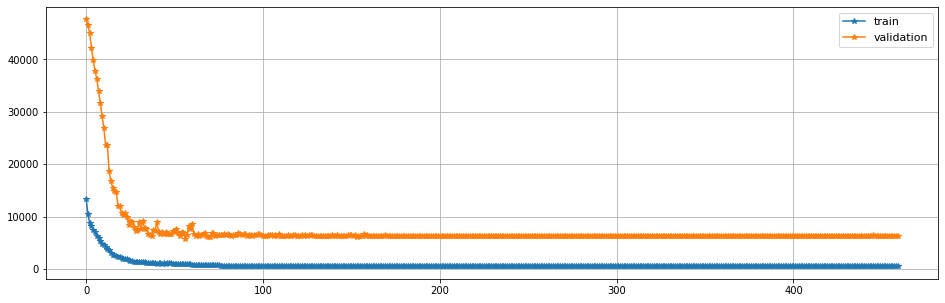

In [21]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [22]:
model_path = folder + 'modelo_best.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [23]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate 
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 100, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/100
76/76 [==============================] - 38s 261ms/step - loss: 1327.5616 - mae: 1327.5616 - val_loss: 8385.2939 - val_mae: 8385.2939
Epoch 2/100
76/76 [==============================] - 18s 237ms/step - loss: 1230.4554 - mae: 1230.4554 - val_loss: 7100.3286 - val_mae: 7100.3286
Epoch 3/100
76/76 [==============================] - 18s 238ms/step - loss: 792.5289 - mae: 792.5289 - val_loss: 4270.1660 - val_mae: 4270.1660
Epoch 4/100
76/76 [==============================] - 10s 135ms/step - loss: 803.1907 - mae: 803.1907 - val_loss: 4915.4790 - val_mae: 4915.4790
Epoch 5/100
76/76 [==============================] - 12s 158ms/step - loss: 763.3598 - mae: 763.3598 - val_loss: 4626.5425 - val_mae: 4626.5425
Epoch 6/100
76/76 [==============================] - 10s 129ms/step - loss: 694.8098 - mae: 694.8098 - val_loss: 6789.8457 - val_mae: 6789.8457
Epoch 7/100
76/76 [==============================] - 10s 128ms/step - loss: 711.0040 - mae: 711.0040 - val_loss: 5361.2549 - val_mae

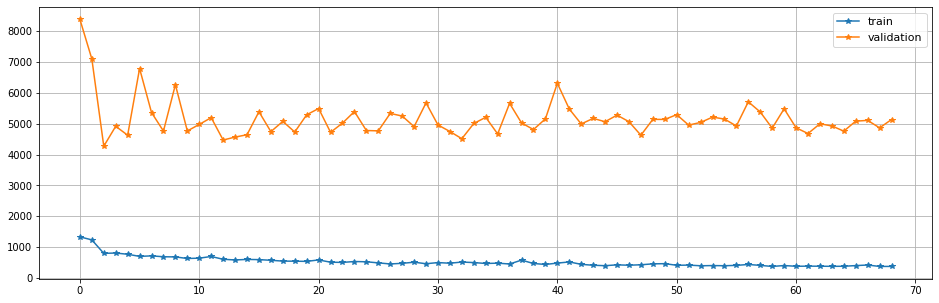

In [24]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [25]:
best_model = tf.keras.models.load_model(model_path)
best_model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 53ms/step - loss: 4270.1665 - mae: 4270.1665


[4270.16650390625, 4270.16650390625]

# Images created 

In [26]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

45/45 [==============================] - 0s 3ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

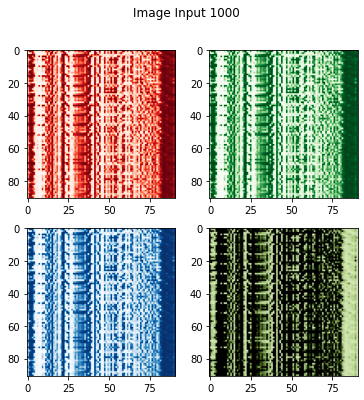

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


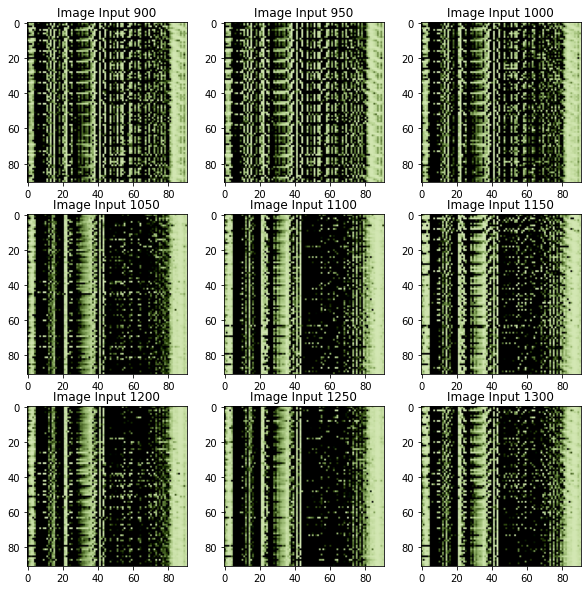

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,1350,50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

In [29]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

45/45 [==============================] - 2s 48ms/step


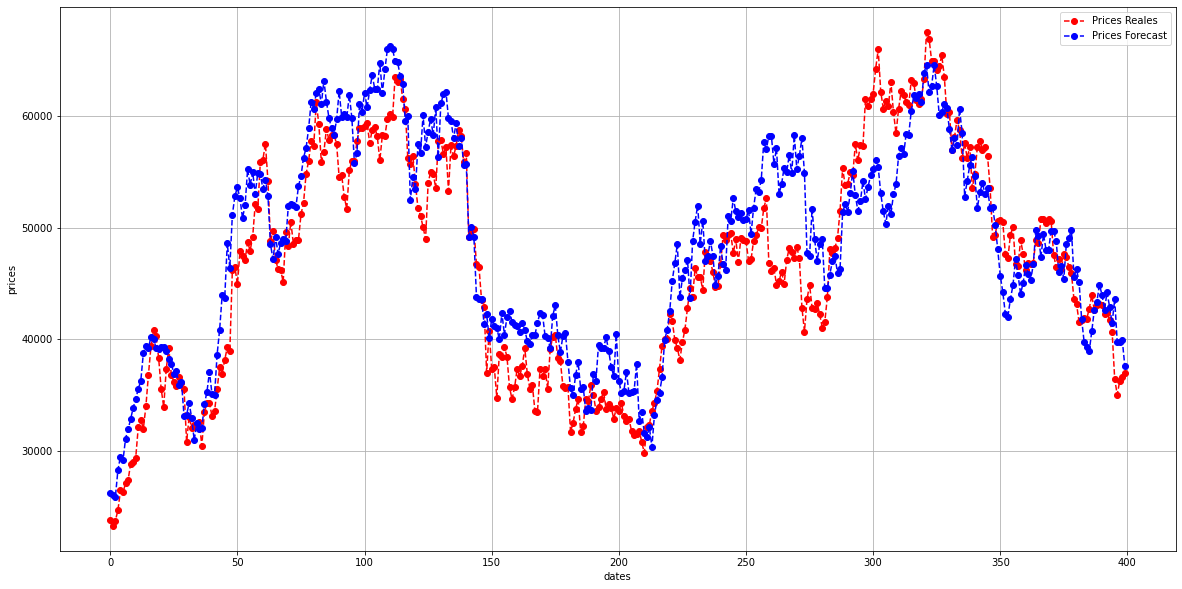

In [39]:
c = 400
day_pred = 0

fig=plt.figure(figsize=(20, 10))
plt.plot(y[-c:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[-c:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [31]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [32]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [33]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count     mean      std    min     25%      50%      75%       max
0  200.0  6422.01  3430.44  659.8  3947.2  5596.91  8267.23  18103.44
Errores Full
    count     mean      std    min    25%     50%      75%       max
0  1412.0  2282.53  2998.38  38.78  436.5  814.05  3227.75  18103.44


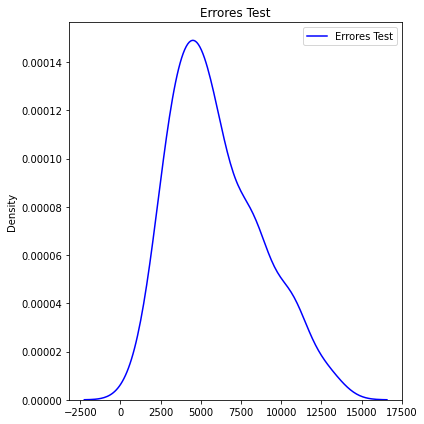

In [34]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

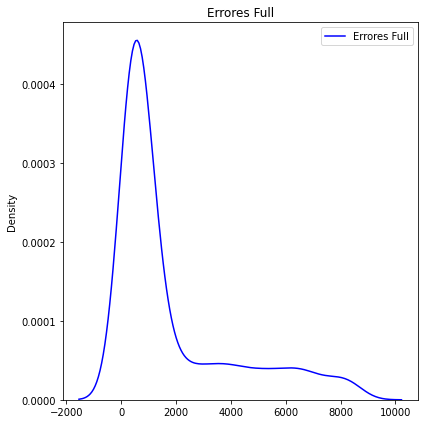

In [35]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [36]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

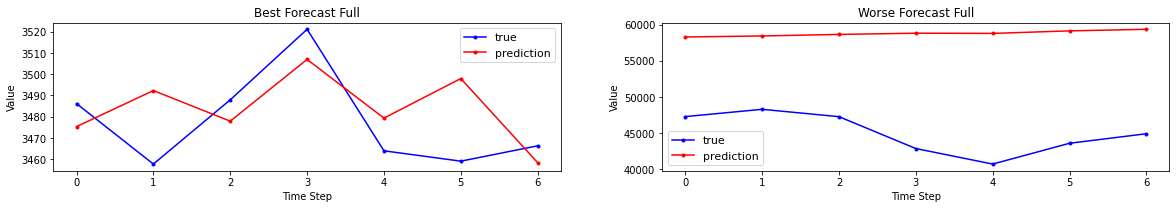

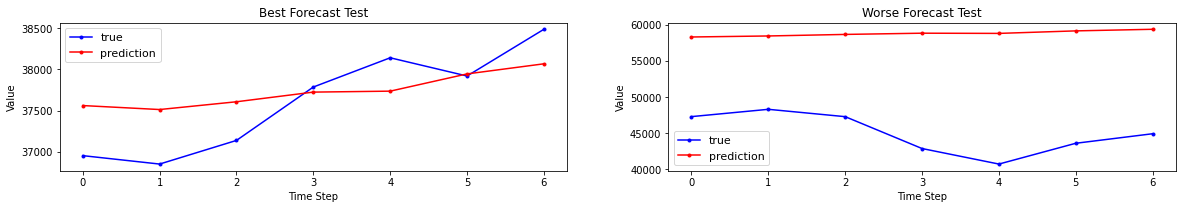

In [37]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();